In [1]:
import os
os.chdir('/home/negreami/project/mmsegmentation')

In [2]:
if not os.path.exists('iccv09Data'):
    !wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
    !tar xf stanford_background.tar.gz

In [3]:
import mmcv
import numpy as np
from PIL import Image
import os.path as osp

data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'

# Define class names and palette
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

# Convert .regions.txt to .png masks
for file in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
    seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', '.png')))

/home/negreami/miniconda3/envs/aisenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/negreami/miniconda3/envs/aisenv/lib/python3.10/site-packages/torch/utils/cpp_extension.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]
/home/negreami/miniconda3/envs/aisenv/lib/python3.10/site-packages/torch/utils/cpp_extension.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package o

In [4]:
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
train_length = int(len(filename_list) * 4 / 5)
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [5]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.png', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [6]:
from mmcv import Config

cfg = Config.fromfile('configs/deeplabv3/deeplabv3_r50-d8_512x1024_40k_cityscapes.py')

# Update config for Stanford Background
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root
cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

cfg.train_pipeline[2]['img_scale'] = (320, 240)
cfg.test_pipeline[1]['img_scale'] = (320, 240)

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# cfg.load_from = 'checkpoints/deeplabv3_r50-d8_512x1024_40k_cityscapes_20200605_022449-acadc2f8.pth'  # Commented out to train from scratch
cfg.work_dir = './work_dirs/stanford_bg_demo'
cfg.runner.max_iters = 400  # Increased from 200 to 400
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

In [7]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor, set_random_seed
import mmcv
import os.path as osp
import os

import torch
torch.multiprocessing.set_start_method('spawn', force=True)

# Remove distributed environment variables if present
os.environ.pop('LOCAL_RANK', None)
os.environ.pop('RANK', None)
os.environ.pop('WORLD_SIZE', None)

set_random_seed(0, deterministic=False)
datasets = [build_dataset(cfg.data.train)]
cfg.model.backbone.pretrained = None

# Ensure no SyncBN is used (replace with BN)
if hasattr(cfg.model.backbone, 'norm_cfg') and cfg.model.backbone.norm_cfg.get('type', None) == 'SyncBN':
    cfg.model.backbone.norm_cfg['type'] = 'BN'
if hasattr(cfg.model.decode_head, 'norm_cfg') and cfg.model.decode_head.norm_cfg.get('type', None) == 'SyncBN':
    cfg.model.decode_head.norm_cfg['type'] = 'BN'
if hasattr(cfg.model, 'auxiliary_head') and hasattr(cfg.model.auxiliary_head, 'norm_cfg') and cfg.model.auxiliary_head.norm_cfg.get('type', None) == 'SyncBN':
    cfg.model.auxiliary_head.norm_cfg['type'] = 'BN'

model = build_segmentor(cfg.model)
model.CLASSES = datasets[0].CLASSES
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
cfg.gpu_ids = [0]
cfg.seed = 0
cfg.device = 'cuda'
cfg.data.workers_per_gpu = 0
cfg.data.persistent_workers = False
cfg.lr_config = dict(policy='poly', power=0.9, min_lr=1e-4, by_epoch=False)

# Remove distributed config fields
cfg.launcher = None
if hasattr(cfg, 'dist_params'):
    cfg.dist_params = None

train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2025-07-08 12:48:13,114 - mmseg - INFO - Loaded 572 images
/home/negreami/project/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/negreami/project/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/negreami/project/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/home/negreami/project/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would li

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 14.6 task/s, elapsed: 10s, ETA:     0s

2025-07-08 13:06:34,409 - mmseg - INFO - per class results:
2025-07-08 13:06:34,411 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 44.25 | 48.22 |
|  tree  | 24.83 | 29.46 |
|  road  | 69.84 | 86.57 |
| grass  | 40.14 | 84.77 |
| water  | 12.18 | 16.44 |
|  bldg  | 41.42 | 80.48 |
|  mntn  |  0.0  |  0.0  |
| fg obj |  13.7 | 15.42 |
+--------+-------+-------+
2025-07-08 13:06:34,412 - mmseg - INFO - Summary:
2025-07-08 13:06:34,413 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 58.25 | 30.79 | 45.17 |
+-------+-------+-------+
2025-07-08 13:06:34,414 - mmseg - INFO - Iter(val) [143]	aAcc: 0.5825, mIoU: 0.3079, mAcc: 0.4517, IoU.sky: 0.4425, IoU.tree: 0.2483, IoU.road: 0.6984, IoU.grass: 0.4014, IoU.water: 0.1218, IoU.bldg: 0.4142, IoU.mntn: 0.0000, IoU.fg obj: 0.1370, Acc.sky: 0.4822, Acc.tree: 0.2946, Acc.road: 0.8657, Acc.grass: 0.8477, Acc.water: 0.1644, Acc.bldg: 0.804

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 143/143, 14.7 task/s, elapsed: 10s, ETA:     0s

2025-07-08 13:24:41,534 - mmseg - INFO - per class results:
2025-07-08 13:24:41,536 - mmseg - INFO - 
+--------+-------+-------+
| Class  |  IoU  |  Acc  |
+--------+-------+-------+
|  sky   | 64.98 | 71.13 |
|  tree  | 31.11 | 38.25 |
|  road  | 68.56 | 80.01 |
| grass  | 57.87 | 80.03 |
| water  | 13.68 | 21.07 |
|  bldg  |  48.2 | 84.77 |
|  mntn  |  0.0  |  0.0  |
| fg obj |  26.0 |  34.2 |
+--------+-------+-------+
2025-07-08 13:24:41,537 - mmseg - INFO - Summary:
2025-07-08 13:24:41,537 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 64.8 | 38.8 | 51.18 |
+------+------+-------+
2025-07-08 13:24:41,539 - mmseg - INFO - Iter(val) [143]	aAcc: 0.6480, mIoU: 0.3880, mAcc: 0.5118, IoU.sky: 0.6498, IoU.tree: 0.3111, IoU.road: 0.6856, IoU.grass: 0.5787, IoU.water: 0.1368, IoU.bldg: 0.4820, IoU.mntn: 0.0000, IoU.fg obj: 0.2600, Acc.sky: 0.7113, Acc.tree: 0.3825, Acc.road: 0.8001, Acc.grass: 0.8003, Acc.water: 0.2107, Acc.bldg: 0.8477, Acc.mnt

<Figure size 800x600 with 0 Axes>

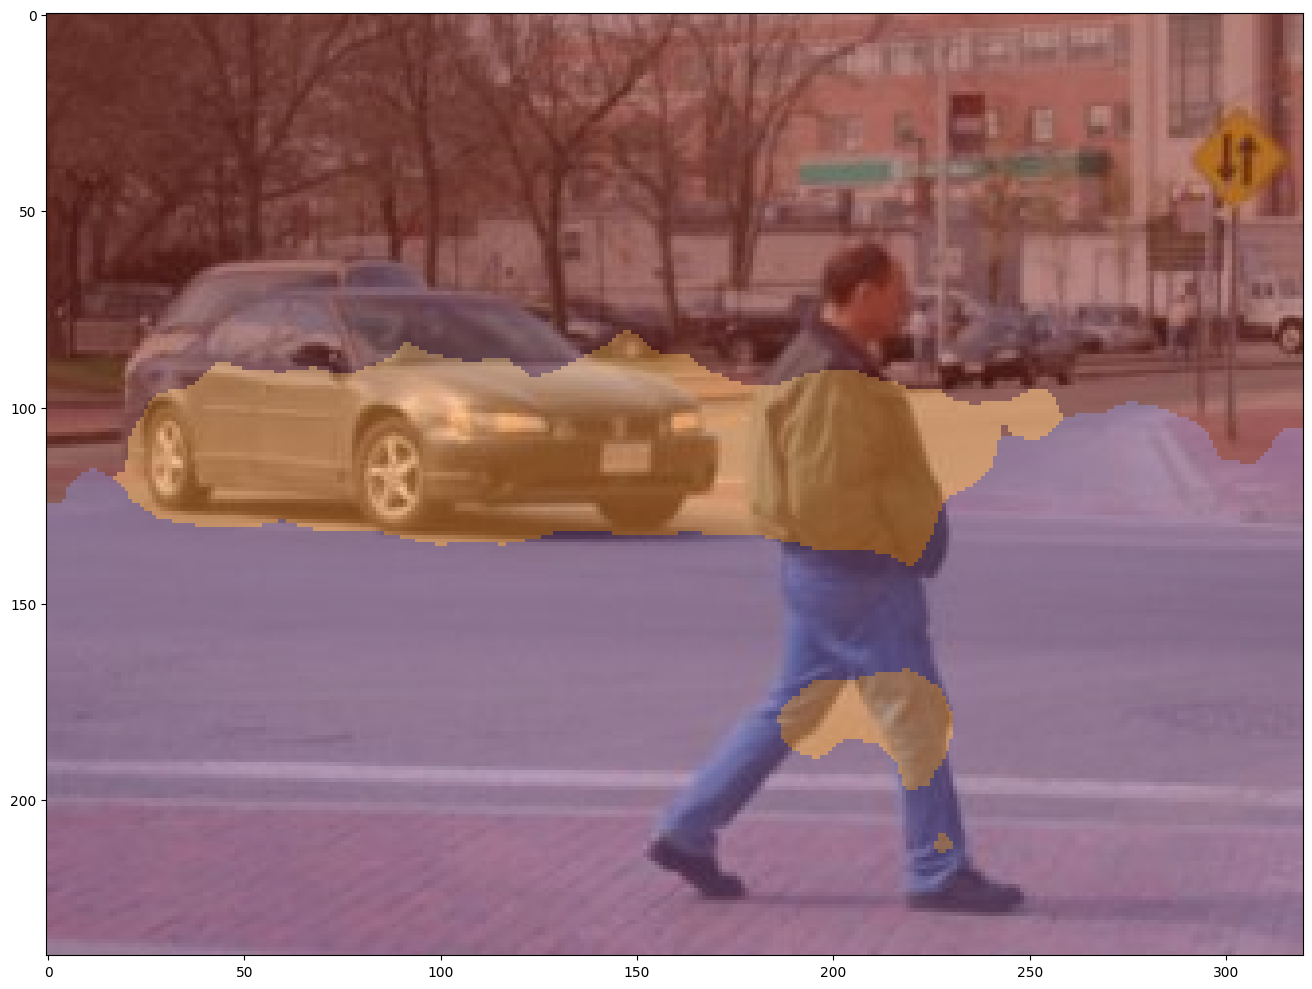

In [9]:
import mmcv
import matplotlib.pyplot as plt
from mmseg.apis import inference_segmentor, show_result_pyplot

img = mmcv.imread('iccv09Data/images/6000124.jpg')
model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)